# Fourier slice integration

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax.numpy as jnp

import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb


atom_positions, atom_identities = read_atoms_from_pdb("./data/5w0s.pdb")
atom_potential = cxs.PengAtomicPotential(atom_positions, atom_identities)

In [5]:
# Evaluate the potential on a voxel grid
shape = (240, 240, 240)
voxel_size = 1.0
real_voxel_grid = atom_potential.as_real_voxel_grid(
    shape,
    voxel_size,
    z_planes_in_parallel=10,
)

In [6]:
from cryojax.image import downsample_with_fourier_cropping


downsampling_factor = 3
downsampled_voxel_size = downsampling_factor * voxel_size
downsampled_voxel_grid = downsample_with_fourier_cropping(
    real_voxel_grid, downsampling_factor
)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    downsampled_voxel_grid, downsampled_voxel_size
)

In [7]:
from cryojax.image import irfftn


potential_integrator = cxs.FourierSliceExtraction(interpolation_order=1)
instrument_config = cxs.InstrumentConfig(
    shape=potential.shape[0:2],
    pixel_size=potential.voxel_size,
    voltage_in_kilovolts=300.0,
)
fourier_integrated_potential = potential_integrator.compute_fourier_integrated_potential(
    potential, instrument_config
)
projection = irfftn(fourier_integrated_potential, s=instrument_config.shape)

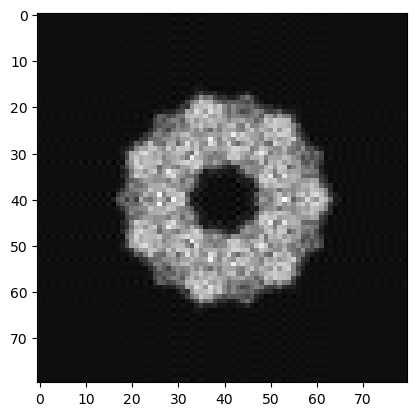

In [8]:
import matplotlib.pyplot as plt


plt.imshow(projection, cmap="gray")

# Multislice integrator

In [9]:
downsampling_factor = 3
downsampled_voxel_size = downsampling_factor * voxel_size
downsampled_voxel_grid = downsample_with_fourier_cropping(
    real_voxel_grid, downsampling_factor
)
potential = cxs.RealVoxelGridPotential.from_real_voxel_grid(
    downsampled_voxel_grid, downsampled_voxel_size
)

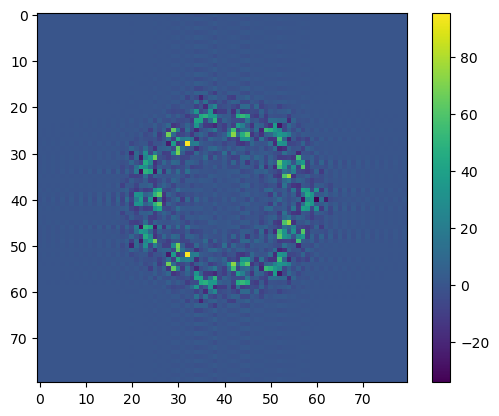

In [10]:
plt.imshow(potential.real_voxel_grid[40])
plt.colorbar()

In [11]:
instrument_config = cxs.InstrumentConfig(
    shape=potential.shape[0:2],
    pixel_size=potential.voxel_size,
    voltage_in_kilovolts=300.0,
)

In [12]:
dir(instrument_config)

['__abstractclassvars__',
 '__abstractmethods__',
 '__abstractvars__',
 '__annotations__',
 '__check_init__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 'coordinate_grid_in_angstroms',
 'coordinate_grid_in_pixels',
 'crop_or_pad_to_padded_shape',
 'crop_to_shape',
 'electrons_per_angstrom_squared',
 'frequency_grid_in_angstroms',
 'frequency_grid_in_pixels',
 'full_frequency_grid_in_angstroms',
 'full_frequency_grid_in_pixels',
 'n_pixels',
 'pad_mode',
 'pad_to_padded_shape',
 'padded_coordinate_grid_in_angstroms',
 'padded_coordinate_grid_in_pixels',
 'padded_frequency_grid_in_ang

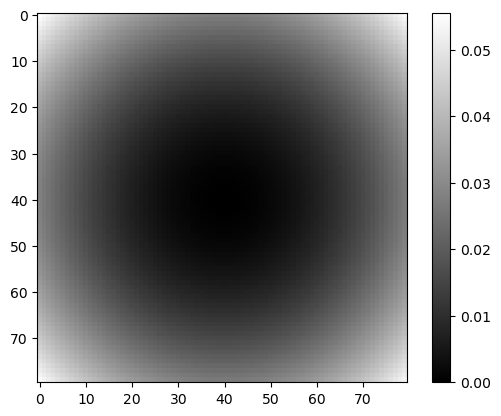

In [13]:
kx, ky = instrument_config.padded_full_frequency_grid_in_angstroms.T
k2 = jnp.hypot(kx, ky) ** 2
plt.imshow(jnp.fft.fftshift(k2), cmap="gray")
plt.colorbar()

In [14]:
from cryojax.experimental import MultisliceIntegrator

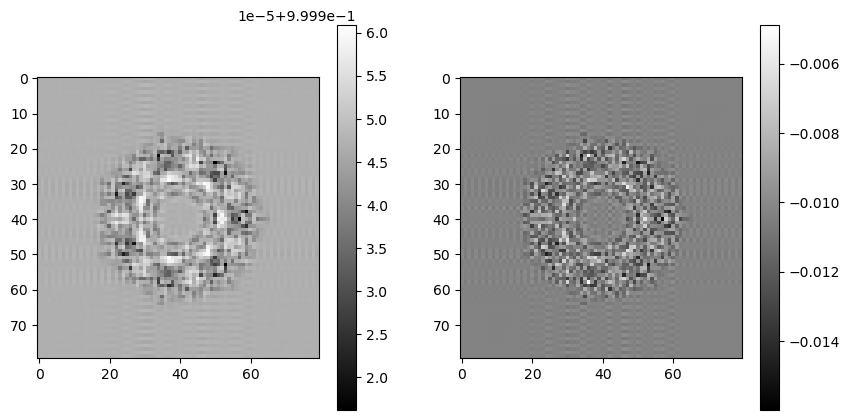

In [27]:
multislice_integrator = MultisliceIntegrator()

exit_wave = multislice_integrator.compute_wavefunction_at_exit_plane(
    potential, instrument_config
)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im0 = axes[0].imshow(exit_wave.real, cmap="gray")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(exit_wave.imag, cmap="gray")
fig.colorbar(im1, ax=axes[1])

In [28]:
import cryojax.experimental as cxe


pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    view_phi=20.0,
    view_theta=80.0,
    view_psi=-5.0,
)
structural_ensemble = cxs.SingleStructureEnsemble(potential, pose)

wtf = cxe.WaveTransferFunction(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
    amplitude_contrast_ratio=0.1,
)
transfer_theory = cxe.WaveTransferTheory(wtf)

In [29]:
from cryojax.experimental import MultisliceScatteringTheory  # cxe


scattering_theory = MultisliceScatteringTheory(
    structural_ensemble, multislice_integrator, transfer_theory
)

In [30]:
imaging_pipeline = cxs.IntensityImagingPipeline(instrument_config, scattering_theory)

image = imaging_pipeline.render()

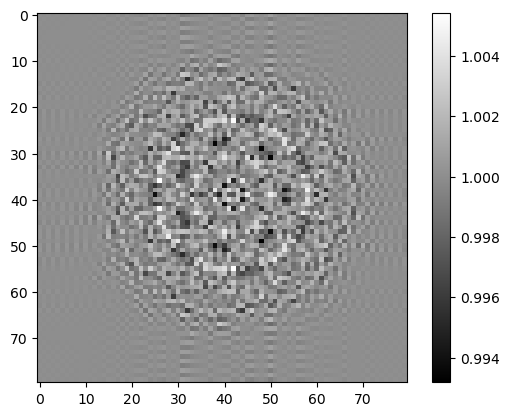

In [31]:
plt.imshow(image, cmap="gray")
plt.colorbar()